# Subsetting 111001001 all features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 917, 1299) with all features.

We note that houses with a basement or garage have additional features, which might improve the regression.  We will explore the best way to exploit this by considering subsets of the data.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit, StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111001001.csv")
test_df = pd.read_csv("./input/test_tidy_111001001.csv")

## Garage

In [13]:
df[df['NoGarage']==1].shape

(80, 347)

Only 80 of the houses in the training data have no garage.  Let us set a baseline validation error for when we don't subset.

In [14]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

In [16]:
lassolarscv_regr = linear_model.LassoLarsCV()
baseline = validate(lassolarscv_regr)
baseline

0.09813879414399386

Now we restrict to houses with a garage.

In [9]:
df_hasg = df[df['NoGarage']==0]

In [18]:
X = df_hasg.values

for train_idx, validation_idx in ss.split(X):
    train_df = df_hasg.iloc[train_idx]
    validation_df = df_hasg.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice'],axis=1).values

In [19]:
hasg = validate(lassolarscv_regr)
(hasg, hasg - baseline)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 221 iterations, i.e. alpha=4.151e-05, with an active set of 181 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 247 iterations, i.e. alpha=2.892e-05, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 254 iterations, i.e. alpha=2.771e-05, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

(0.10362720242916471, 0.0054884082851708454)

In this case, our validation error has increased.  This could be due to sample size.

## Basements

Let's examine the houses with basements. Only 37 houses have no basement.

In [20]:
df[df['NoBasement']==1].shape

(37, 347)

In [10]:
df_hasb = df[df['NoBasement']==0]

In [22]:
X = df_hasb.values

for train_idx, validation_idx in ss.split(X):
    train_df = df_hasb.iloc[train_idx]
    validation_df = df_hasb.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

In [23]:
hasb = validate(lassolarscv_regr)
(hasb, hasb - baseline)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 140 iterations, i.e. alpha=1.009e-04, with an active set of 128 regressors, and the smallest cholesky pivot element being 3.650e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 178 iterations, i.e. alpha=5.851e-05, with an active set of 158 regressors, and the smallest cholesky pivot element being 4.470e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 200 iterations, i.e. alpha=4.006e-05, with an active set of 176 regressors, and the smallest cholesky pivot element being 4.829e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

(0.11809107559831163, 0.019952281454317766)

Here, our validation error is even worse than in the garage case.

## Garage and Basement

In [11]:
df_hasgb = df_hasg[df_hasg['NoBasement']==0]
df_hasgb.shape

(1345, 347)

1345 houses have both a garage and basement.

In [27]:
X = df_hasgb.values

for train_idx, validation_idx in ss.split(X):
    train_df = df_hasgb.iloc[train_idx]
    validation_df = df_hasgb.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice'],axis=1).values

In [28]:
hasgb = validate(lassolarscv_regr)
(hasgb, hasgb - baseline)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 158 iterations, i.e. alpha=7.032e-05, with an active set of 136 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 169 iterations, i.e. alpha=5.851e-05, with an active set of 145 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 262 iterations, i.e. alpha=1.911e-05, with an active set of 212 regressors, and the smallest cholesky pivot element being 8.689e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

(0.090674318810134838, -0.007464475333859022)

This is a small improvement over the baseline.  We will now work out a scheme to make a separate fit on this subset and then combine the predictions.

## Modeling on Subsets

Let's store a dataframe that is the complement of df_hasgb.

In [12]:
df_nogorb = df[(df['NoGarage']==1) | (df['NoBasement']==1)]
df_nogorb.shape 

(110, 347)

We'll build the validation set from the full dataset

In [30]:
X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]

We will split the training set

In [31]:
train_df_hasgb = train_df[(train_df['NoGarage']==0) & (train_df['NoBasement']==0)]
train_df_nogorb = train_df[(train_df['NoGarage']==1) | (train_df['NoBasement']==1)]

We need to fit models on the appropriate training data.

In [32]:
llcv_hasgb_regr = linear_model.LassoLarsCV()
llcv_nogorb_regr = linear_model.LassoLarsCV()

In [33]:
y_train_nogorb = train_df['SalePrice'].values
x_train_nogorb = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train_hasgb = train_df_hasgb['SalePrice'].values
x_train_hasgb = train_df_hasgb.drop(['HouseId', 'SalePrice'],axis=1).values

In [34]:
llcv_hasgb_regr.fit(x_train_hasgb, y_train_hasgb)
llcv_nogorb_regr.fit(x_train_nogorb, y_train_nogorb)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 358 iterations, alpha=6.045e-05, previous alpha=4.254e-06, with an active set of 245 regressors.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 251 iterations, i.e. alpha=2.428e-05, with an active set of 205 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 278 iterations, i.e. alpha=1.738e-05, with an active set of 212 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/skl

LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)

In [36]:
validation_df_hasgb = validation_df[(validation_df['NoGarage']==0) & (validation_df['NoBasement']==0)]
validation_df_nogorb = validation_df[(validation_df['NoGarage']==1) | (validation_df['NoBasement']==1)]

In [37]:
y_validation_nogorb = validation_df_nogorb['SalePrice'].values
x_validation_nogorb = validation_df_nogorb.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_validation_hasgb = validation_df_hasgb['SalePrice'].values
x_validation_hasgb = validation_df_hasgb.drop(['HouseId', 'SalePrice'],axis=1).values

In [38]:
y_pred_hasgb = llcv_hasgb_regr.predict(x_validation_hasgb)
y_pred_nogorb = llcv_nogorb_regr.predict(x_validation_nogorb)

In [47]:
y_validation = np.append(y_validation_nogorb,y_validation_hasgb)

In [49]:
y_pred = np.append(y_pred_nogorb,y_pred_hasgb)

In [51]:
error = rmse(y_validation, y_pred) 
(error, error-baseline)

(0.097617740578592849, -0.00052105356540101122)

The improvement over the baseline is in line with the previous result.

## Refitting on the Full Training Set

Before passing to the Kaggle test set, let's fit LassoLars models on the whole training data.  

In [13]:
y_train_nogorb = df['SalePrice'].values
x_train_nogorb = df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train_hasgb = df_hasgb['SalePrice'].values
x_train_hasgb = df_hasgb.drop(['HouseId', 'SalePrice'],axis=1).values

LassoLars had the best results from our modeling experiments, so we'll continue using it, but we'll hand tune the L1 regularization parameter.

In [14]:
x_train = x_train_nogorb
y_train = y_train_nogorb

,alpha,RMSE,std dev
5,0.00013000000000000002,0.10502000092254368258,0.05461958043298760501
4,0.00012000000000000000,0.10477200102536989024,0.05451735550256560370
3,0.00011000000000000000,0.10454164113773441180,0.05449536807608087313
0,0.00008000000000000001,0.10442676026475859741,0.05431687940797252229
2,0.00010000000000000000,0.10440270056663149278,0.05445563223384845830
1,0.00009000000000000001,0.10437857300346860268,0.05437406755388812102


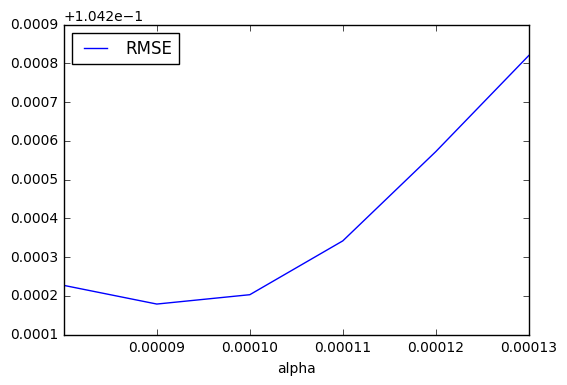

In [55]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)
lassolars_params = {'alpha': np.arange(0.00008, 0.00014, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [15]:
ll_nogorb_regr = linear_model.LassoLars(alpha=0.00009, max_iter=50000)

In [57]:
x_train = x_train_hasgb
y_train = y_train_hasgb

,alpha,RMSE,std dev
0,0.00004000000000000000,0.10059995082499828545,0.05240906069643299497
1,0.00005000000000000000,0.10019881333907293408,0.05211395398664721984
6,0.00009999999999999999,0.10003418914599260248,0.05103147483232799153
2,0.00006000000000000000,0.09996341452685413020,0.05193133207806619606
5,0.00008999999999999999,0.09988665339497991569,0.05123906613469816212
3,0.00006999999999999999,0.09983026887293371121,0.05172378798250429344
4,0.00007999999999999999,0.09981009551691903681,0.05150360372597920927


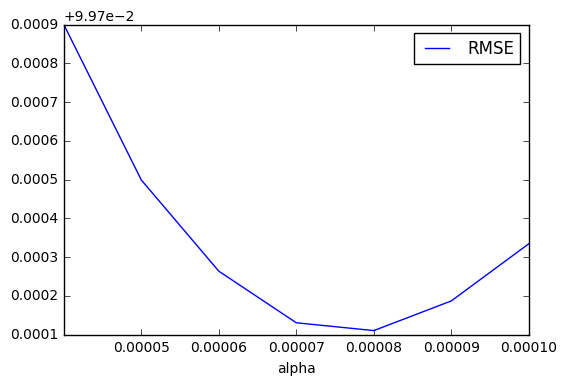

In [60]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)
lassolars_params = {'alpha': np.arange(0.00004, 0.00011, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [16]:
ll_hasgb_regr = linear_model.LassoLars(alpha=0.00008, max_iter=50000)

In [17]:
ll_hasgb_regr.fit(x_train_hasgb, y_train_hasgb)

LassoLars(alpha=8e-05, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=50000, normalize=True,
     positive=False, precompute='auto', verbose=False)

In [22]:
lassolars_features = zip(df_hasgb.drop(['HouseId','SalePrice'],axis=1).columns, ll_hasgb_regr.coef_)
lassolars_features_df = pd.DataFrame.from_dict(lassolars_features)
lassolars_features_df.columns = ["Feature", "Coeff"]
lassolars_features_df = lassolars_features_df[lassolars_features_df["Coeff"]!=0]
lassolars_features_df["sort_ind"] = abs(lassolars_features_df["Coeff"])
lassolars_features_df = lassolars_features_df.sort_values(by="sort_ind", ascending = False)
lassolars_features_df = lassolars_features_df.drop('sort_ind', 1)

In [23]:
lassolars_features_df

,Feature,Coeff
339,AreasSum,0.38203891676775314501
83,OverallQual,0.37208623725056499953
166,GrLivArea,0.36514422311452221503
338,AllSizesSumLin,0.30674465472866635496
172,KitchenAbvGr,-0.29380727026738667762
340,LivArea,0.28408310389312485533
84,OverallCond,0.22527445550683075637
319,AgeLin,0.14541605921650005429
12,MSZoning.C..all.,-0.14186218297738265037
341,LivAreaWt,0.14024849690939039659


In [24]:
ll_nogorb_regr.fit(x_train_nogorb, y_train_nogorb)

LassoLars(alpha=9e-05, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=50000, normalize=True,
     positive=False, precompute='auto', verbose=False)

In [25]:
lassolars_features = zip(df_nogorb.drop(['HouseId','SalePrice'],axis=1).columns, ll_nogorb_regr.coef_)
lassolars_features_df = pd.DataFrame.from_dict(lassolars_features)
lassolars_features_df.columns = ["Feature", "Coeff"]
lassolars_features_df = lassolars_features_df[lassolars_features_df["Coeff"]!=0]
lassolars_features_df["sort_ind"] = abs(lassolars_features_df["Coeff"])
lassolars_features_df = lassolars_features_df.sort_values(by="sort_ind", ascending = False)
lassolars_features_df = lassolars_features_df.drop('sort_ind', 1)

In [26]:
lassolars_features_df 

,Feature,Coeff
339,AreasSum,0.41012986677174911865
83,OverallQual,0.38029700075745137555
341,LivAreaWt,0.33945587604751142896
338,AllSizesSumLin,0.33254889039200191680
84,OverallCond,0.23686755533717973599
340,LivArea,0.20250088266719520891
166,GrLivArea,0.18220243937436783610
172,KitchenAbvGr,-0.18064891385722950390
318,Age,-0.12059888776177191128
310,SaleConditionnums,0.09528796766179176148


## Making Predictions on the Test Set

We want to be able to reassemble subset predictions on the test set back into a dataframe matched on the correct HouseId.

In [110]:
test_df_hasgb = test_df[(test_df['NoGarage']==0) & (test_df['NoBasement']==0)].reset_index(drop=True)
test_df_nogorb = test_df[(test_df['NoGarage']==1) | (test_df['NoBasement']==1)].reset_index(drop=True)

In [89]:
x_test_nogorb = test_df_nogorb.drop(['HouseId', 'GarageAge', 'GarageAgeLin'],axis=1).values
x_test_hasgb = test_df_hasgb.drop(['HouseId'],axis=1).values

In [139]:
y_pred_hasgb = ll_hasgb_regr.predict(x_test_hasgb)
y_pred_nogorb = ll_nogorb_regr.predict(x_test_nogorb)

y_pred_hasgb = np.exp(y_pred_hasgb)
y_pred_nogorb = np.exp(y_pred_nogorb)

In [140]:
ids_hasgb = test_df_hasgb.loc[:,'HouseId'].tolist()
ids_nogorb = test_df_nogorb.loc[:,'HouseId'].tolist()

In [141]:
nogorb_preds = zip(ids_nogorb, y_pred_nogorb)
nogorb_preds_df = pd.DataFrame.from_dict(nogorb_preds)
nogorb_preds_df.columns = ["HouseId", "SalePrice"]

hasgb_preds = zip(ids_hasgb, y_pred_hasgb)
hasgb_preds_df = pd.DataFrame.from_dict(hasgb_preds)
hasgb_preds_df.columns = ["HouseId", "SalePrice"]

In [142]:
preds_df = pd.concat([nogorb_preds_df,hasgb_preds_df]).sort_values('HouseId').set_index('HouseId')

In [144]:
preds_df.to_csv('subset_output-111001001.csv', header=True, index_label='Id')

This results in an error of 0.11998 on the public leaderboard, for a position of 936th on 2/20/17.

## Blending with XGBoost and MLP

We can try to do a bit better by fitting XGBoost and MLP regressors to the data and making additional predictions.

### XGBoost

In [145]:
x_train = x_train_nogorb
y_train = y_train_nogorb

,max_depth,RMSE,std dev
0,1.0,0.11488772707413609508,0.05255567374183525708
7,8.0,0.11371224098954894888,0.05076517862737173897
6,7.0,0.11218566353463792218,0.05200902529169261490
4,5.0,0.11217345446732565617,0.05386252862767619554
3,4.0,0.11216396517572302383,0.05574826149357729743
5,6.0,0.11197797475206651419,0.05149344352390237967
1,2.0,0.11122383231362803491,0.05480122217021001635
2,3.0,0.11022172069205109224,0.05589942710242555568


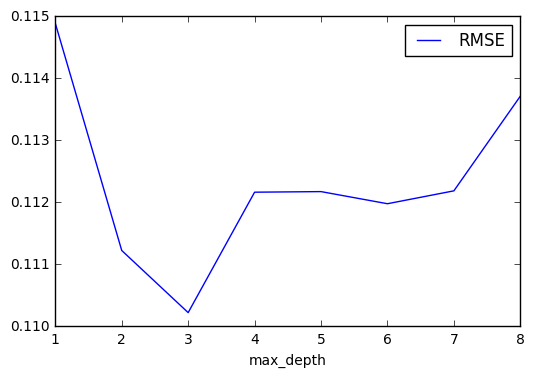

In [161]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 3, 
    min_child_weight = 6.25,
    gamma = 0.0005,
    subsample = 0.4,
    colsample_bytree = 0.3,
    reg_alpha = 0.1,
    reg_lambda = 3.25, 
    learning_rate = 0.06,
    n_estimators = 500,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'max_depth': np.arange(1, 9, 1).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['max_depth'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [206]:
xgb_nogorb_regr = xgb.XGBRegressor(
    max_depth = 3, 
    min_child_weight = 6.25,
    gamma = 0.0005,
    subsample = 0.4,
    colsample_bytree = 0.3,
    reg_alpha = 0.1,
    reg_lambda = 3.25, 
    learning_rate = 0.06,
    n_estimators = 500,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [163]:
x_train = x_train_hasgb
y_train = y_train_hasgb

,max_depth,RMSE,std dev
4,5.0,0.10883609827841995987,0.05650128996558657218
0,1.0,0.10834593098883134321,0.05272099918629982035
3,4.0,0.10774888950454976355,0.05511519880076833772
2,3.0,0.10545443900161750872,0.05353276962508877329
1,2.0,0.10531475929466539709,0.05179772584662591800


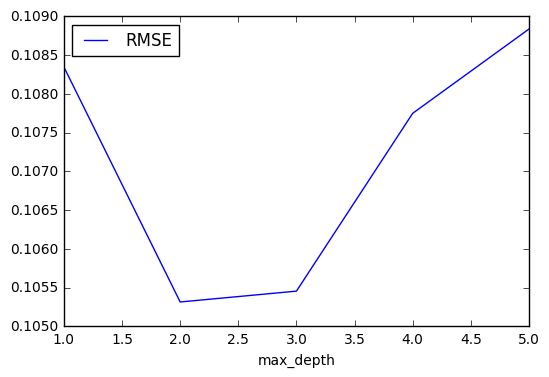

In [179]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 2, 
    min_child_weight = 1,
    gamma = 0.001,
    subsample = 0.7,
    colsample_bytree = 0.105,
    reg_alpha = 0.35,
    reg_lambda = 2.5, 
    learning_rate = 0.06,
    n_estimators = 800,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'max_depth': np.arange(1, 6, 1).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['max_depth'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [207]:
xgb_hasgb_regr = xgb.XGBRegressor(
    max_depth = 2, 
    min_child_weight = 1,
    gamma = 0.001,
    subsample = 0.7,
    colsample_bytree = 0.105,
    reg_alpha = 0.35,
    reg_lambda = 2.5, 
    learning_rate = 0.06,
    n_estimators = 800,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [208]:
xgb_nogorb_regr.fit(x_train_nogorb, y_train_nogorb)
xgb_hasgb_regr.fit(x_train_hasgb, y_train_hasgb)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.105,
       gamma=0.001, learning_rate=0.06, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=800, nthread=-1,
       objective='reg:linear', reg_alpha=0.35, reg_lambda=2.5,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.7)

### Multilevel Perceptron

In [181]:
x_train = x_train_nogorb
y_train = y_train_nogorb

,max_iter,RMSE,std dev
0,25.0,0.29908575000819082046,0.11876997154703844428
1,50.0,0.17027111420756918525,0.08401653573108444628
2,75.0,0.14160940084410589268,0.05309303777329380664
3,100.0,0.13201830812713336027,0.05505191691268000037
4,125.0,0.12591422120061823708,0.05796863529395872988
5,150.0,0.12240037662874428404,0.05703646879461149455
6,175.0,0.12032256765074218763,0.05743404362097773164
7,200.0,0.11850118164847837920,0.05884209209803563378
8,225.0,0.11746927908339496738,0.05691106611736058973
11,300.0,0.11681115631010186018,0.05580812164061162151


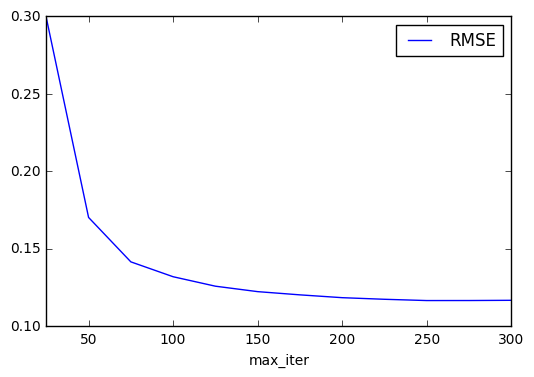

In [190]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(9, ),
                        alpha=0.0004, 
                        tol=0.0004, 
                        max_iter=250)
mlp_params = {'max_iter': np.arange(25, 325, 25).tolist()}
# mlp_params = {'tol': np.logspace(-4, -2, 11).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [191]:
mlp_nogorb_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(9, ),
                        alpha=0.0004, 
                        tol=0.0004, 
                        max_iter=250)

In [192]:
x_train = x_train_hasgb
y_train = y_train_hasgb

,max_iter,RMSE,std dev
1,325.0,0.10838442045677380843,0.04999417370911652531
2,350.0,0.10835197894790828121,0.04960519603978941205
3,375.0,0.10832544819565829985,0.05016212261699106584
4,400.0,0.10830031803423005587,0.05009830056326205344
0,300.0,0.10822575373262892373,0.04993408625363403297


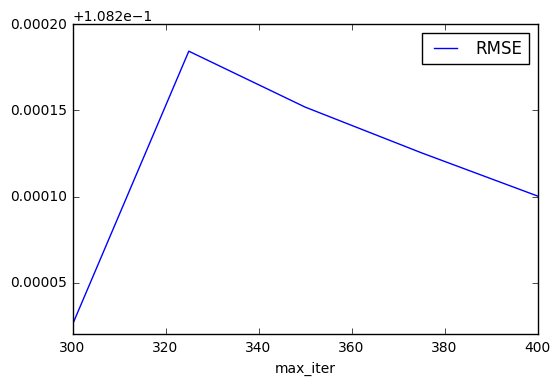

In [199]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.0005, 
                        tol=0.0004, 
                        max_iter=250)
mlp_params = {'max_iter': np.arange(300, 425, 25).tolist()}
# mlp_params = {'tol': np.logspace(-4, -2, 11).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [200]:
mlp_hasgb_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.0005, 
                        tol=0.0004, 
                        max_iter=300)

In [203]:
mlp_nogorb_regr.fit(x_train_nogorb, y_train_nogorb)
mlp_hasgb_regr.fit(x_train_hasgb, y_train_hasgb)

MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=641,
       shuffle=True, solver='lbfgs', tol=0.0004, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Blending Predictions

In [211]:
y_pred_hasgb_ll = ll_hasgb_regr.predict(x_test_hasgb)
y_pred_nogorb_ll = ll_nogorb_regr.predict(x_test_nogorb)

y_pred_hasgb_xgb = xgb_hasgb_regr.predict(x_test_hasgb)
y_pred_nogorb_xgb = xgb_nogorb_regr.predict(x_test_nogorb)

y_pred_hasgb_mlp = mlp_hasgb_regr.predict(x_test_hasgb)
y_pred_nogorb_mlp = mlp_nogorb_regr.predict(x_test_nogorb)

We will weight the predictions according to the cross-validation errors.

In [213]:
y_pred_hasgb = (y_pred_hasgb_ll / 0.0998 + y_pred_hasgb_xgb / 0.1053 
                + y_pred_hasgb_mlp / 0.1082) / (1 / 0.0998 + 1 / 0.1053 + 1 / 0.1082)

y_pred_nogorb = (y_pred_nogorb_ll / 0.1044 + y_pred_nogorb_xgb / 0.11022
                + y_pred_nogorb_mlp / 0.1166) / (1 / 0.1044 + 1 / 0.11022 + 1 / 0.1166)

y_pred_hasgb = np.exp(y_pred_hasgb)
y_pred_nogorb = np.exp(y_pred_nogorb)

In [214]:
ids_hasgb = test_df_hasgb.loc[:,'HouseId'].tolist()
ids_nogorb = test_df_nogorb.loc[:,'HouseId'].tolist()

In [215]:
nogorb_preds = zip(ids_nogorb, y_pred_nogorb)
nogorb_preds_df = pd.DataFrame.from_dict(nogorb_preds)
nogorb_preds_df.columns = ["HouseId", "SalePrice"]

hasgb_preds = zip(ids_hasgb, y_pred_hasgb)
hasgb_preds_df = pd.DataFrame.from_dict(hasgb_preds)
hasgb_preds_df.columns = ["HouseId", "SalePrice"]

In [216]:
preds_df = pd.concat([nogorb_preds_df,hasgb_preds_df]).sort_values('HouseId').set_index('HouseId')

In [217]:
preds_df.to_csv('subset_blend_output-111001001.csv', header=True, index_label='Id')

This yielded a 0.12211 error on the public leaderboard, which was a worse result.  This is likely due to comparably larger variance of the XGB and MLP results, as evidenced by the cross-validation error on the training set.

### Elastic Net

Since the tree and NN models didn't seem to do so well, it might be useful to blend with a different linear model to reduce some variance error. The Elastic Net was the 2nd performer behind LassoLars, so it is a natural choice.

In [218]:
x_train = x_train_nogorb
y_train = y_train_nogorb

,l1_ratio,RMSE,std dev
0,0.10000000000000000555,0.10851441945455396476,0.05413143050096031611
1,0.20000000000000001110,0.10728474594484239957,0.05386529258550314114
8,0.90000000000000002220,0.10677573306873749948,0.05462062717498383790
2,0.30000000000000004441,0.10658991974316117668,0.05436056546318008414
7,0.80000000000000004441,0.10654155398039166780,0.05440054091832015326
6,0.70000000000000006661,0.10640772203929935169,0.05440402587124221895
5,0.59999999999999997780,0.10624516806587051831,0.05449819966729742976
3,0.40000000000000002220,0.10624420846737654689,0.05456913585266731648
4,0.50000000000000000000,0.10613032091837604209,0.05463493466604369547


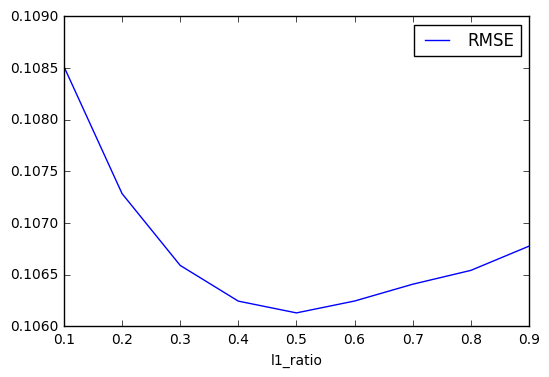

In [220]:
elnet_regr = linear_model.ElasticNet(alpha=0.0006, l1_ratio=0.5, max_iter=15000, random_state=7)
# elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
# elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [221]:
elnet_nogorb_regr = linear_model.ElasticNet(alpha=0.0006, l1_ratio=0.5, max_iter=15000, random_state=7)

In [222]:
x_train = x_train_hasgb
y_train = y_train_hasgb

,l1_ratio,RMSE,std dev
0,0.10000000000000000555,0.10418421666937850711,0.05469609801152416906
1,0.20000000000000001110,0.10273089514678607204,0.05402554780477002161
8,0.90000000000000002220,0.10223977863273230049,0.05206325867923050632
2,0.30000000000000004441,0.10217706811620841378,0.05366037318939575335
7,0.80000000000000004441,0.10196980875921866916,0.05216762989931308242
3,0.40000000000000002220,0.10177937192376577957,0.05342817653819182527
6,0.70000000000000006661,0.10170226307969326696,0.05240252934473502155
4,0.50000000000000000000,0.10155105846001494241,0.05315452999554833025
5,0.59999999999999997780,0.10153176104932667978,0.05269982983783803865


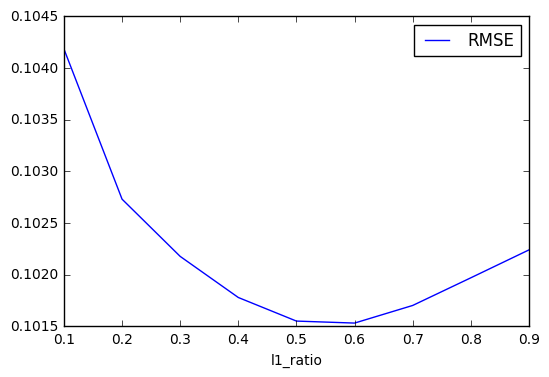

In [224]:
elnet_regr = linear_model.ElasticNet(alpha=0.00055, l1_ratio=0.5, max_iter=15000, random_state=7)
# elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
# elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [225]:
elnet_hasgb_regr = linear_model.ElasticNet(alpha=0.00055, l1_ratio=0.6, max_iter=15000, random_state=7)

In [226]:
elnet_nogorb_regr.fit(x_train_nogorb, y_train_nogorb)
elnet_hasgb_regr.fit(x_train_hasgb, y_train_hasgb)

ElasticNet(alpha=0.00055, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=15000, normalize=False, positive=False, precompute=False,
      random_state=7, selection='cyclic', tol=0.0001, warm_start=False)

In [227]:
y_pred_hasgb_elnet = elnet_hasgb_regr.predict(x_test_hasgb)
y_pred_nogorb_elnet = elnet_nogorb_regr.predict(x_test_nogorb)

In [228]:
y_pred_hasgb = (y_pred_hasgb_ll / 0.0998 + y_pred_hasgb_elnet  / 0.1015 ) / (1 / 0.0998 + 1 / 0.1015)

y_pred_nogorb = (y_pred_nogorb_ll / 0.1044 + y_pred_nogorb_elnet  / 0.1061) / (1 / 0.1044 + 1 / 0.1061)

y_pred_hasgb = np.exp(y_pred_hasgb)
y_pred_nogorb = np.exp(y_pred_nogorb)

In [229]:
nogorb_preds = zip(ids_nogorb, y_pred_nogorb)
nogorb_preds_df = pd.DataFrame.from_dict(nogorb_preds)
nogorb_preds_df.columns = ["HouseId", "SalePrice"]

hasgb_preds = zip(ids_hasgb, y_pred_hasgb)
hasgb_preds_df = pd.DataFrame.from_dict(hasgb_preds)
hasgb_preds_df.columns = ["HouseId", "SalePrice"]

In [230]:
preds_df = pd.concat([nogorb_preds_df,hasgb_preds_df]).sort_values('HouseId').set_index('HouseId')

In [231]:
preds_df.to_csv('subset_linearblend_output-111001001.csv', header=True, index_label='Id')

This result gets 0.12049 on the public leaderboard, which is better than the multimodel blend above, but not as good as the original LassoLars entry.